In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from ReliefF import ReliefF
from sklearn.multiclass import OneVsOneClassifier

In [2]:
root = "../../../../"

In [3]:
df = pd.read_csv(root + "datasets/multiclass/processed/CICDDoS_corr.csv", index_col=[0])

In [4]:
df.head()

,Total Fwd Packets,Total Backward Packets,Total Length of Bwd Packets,Fwd Packet Length Min,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Flow Bytes/s,Flow Packets/s,...,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Active Mean,Active Std,Idle Std,Idle Min,Label
0,2.0,0.0,0.0,1368.0,0.0,0.0,0.0,0.0,2.736000e+09,2000000.00,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,DrDoS_DNS
1,2.0,0.0,0.0,1325.0,0.0,0.0,0.0,0.0,2.650000e+09,2000000.00,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
2,2.0,0.0,0.0,1472.0,0.0,0.0,0.0,0.0,1.472000e+09,1000000.00,...,0.0,0.0,1.0,1.0,14.0,0.0,0.0,0.0,0.0,DrDoS_DNS
3,2.0,0.0,0.0,1472.0,0.0,0.0,0.0,0.0,6.400000e+07,43478.26,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,DrDoS_DNS
4,2.0,0.0,0.0,1472.0,0.0,0.0,0.0,0.0,2.944000e+09,2000000.00,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,DrDoS_DNS


In [5]:
X = df.drop(columns=[' Label'])
y = df[' Label']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42, stratify=y)

___
# Select the top 20 features

In [7]:
clf_xgb_gain = xgb.XGBClassifier(seed=42)
# clf_xgb.fit(X_train, 
#             y_train,
#             verbose=True,
#             ## the next three arguments set up early stopping.
#             early_stopping_rounds=5,
#             eval_metric='mlogloss',
#             eval_set=[(X_test, y_test)])
clf_xgb_gain.fit(X_train, y_train)
xgb_gain = clf_xgb_gain.feature_importances_

anova = f_classif(X_train, y_train)[0]

mi = mutual_info_classif(X_train, y_train)

relieff = ReliefF(n_neighbors=20, n_features_to_keep=20)
relieff.fit(X_train.to_numpy(),y_train.to_numpy())
relief = relieff.feature_scores

feature_df = pd.DataFrame(columns=["anova", "mi", "relief", "xgb_gain"])
feature_df["anova"] = anova
feature_df["mi"] = mi
feature_df["relief"] = relief
feature_df["xgb_gain"] = xgb_gain
feature_df.index = X.columns

for method in feature_df.columns:
    feature_df[method + '_rank'] = feature_df[method].rank(method='first')

ranks = [column for column in feature_df.columns if 'rank' in column]
feature_df['wrfs'] = feature_df[ranks].sum(axis=1)
feature_df.sort_values(by='wrfs', ascending=False, inplace=True)

features_to_keep = feature_df.index[:20]
X_train = X_train[features_to_keep]
X_test = X_test[features_to_keep]

C:\Users\pedro\miniconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[23:49:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


___
# Training a model

In [8]:
clf_xgb = xgb.XGBClassifier(seed=42)
# clf_xgb.fit(X_train, 
#             y_train,
#             verbose=True,
#             ## the next three arguments set up early stopping.
#             early_stopping_rounds=5,
#             eval_metric='mlogloss',
#             eval_set=[(X_test, y_test)])
ovo = OneVsOneClassifier(clf_xgb)
#clf_xgb.fit(X_train, y_train)
ovo.fit(X_train, y_train)

bjective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
C:\Users\pedro\miniconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pedro\miniconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label en

OneVsOneClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

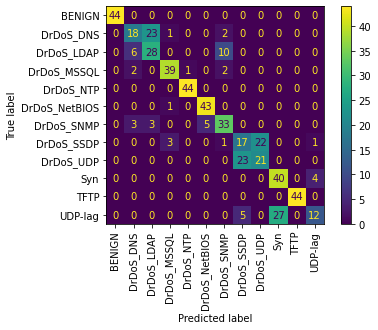

In [9]:
plot_confusion_matrix(ovo, 
                      X_test.values, 
                      y_test,
                      values_format='d',
                      xticks_rotation='vertical')
plt.savefig(root + 'pictures/multiclass_one_vs_one/cm_wrfs.png', bbox_inches='tight')

In [10]:
y_pred = ovo.predict(X_test.values)

In [11]:
print(classification_report(y_test, y_pred, digits=4))

               precision    recall  f1-score   support

       BENIGN     1.0000    1.0000    1.0000        44
    DrDoS_DNS     0.6207    0.4091    0.4932        44
   DrDoS_LDAP     0.5185    0.6364    0.5714        44
  DrDoS_MSSQL     0.8864    0.8864    0.8864        44
    DrDoS_NTP     0.9778    1.0000    0.9888        44
DrDoS_NetBIOS     0.8958    0.9773    0.9348        44
   DrDoS_SNMP     0.6875    0.7500    0.7174        44
   DrDoS_SSDP     0.3778    0.3864    0.3820        44
    DrDoS_UDP     0.4884    0.4773    0.4828        44
          Syn     0.5970    0.9091    0.7207        44
         TFTP     1.0000    1.0000    1.0000        44
      UDP-lag     0.7059    0.2727    0.3934        44

     accuracy                         0.7254       528
    macro avg     0.7296    0.7254    0.7142       528
 weighted avg     0.7296    0.7254    0.7142       528

